## Imports

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Load & prepare data

In [ ]:
# Load dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/NYC_property_sales_regression/sales_pluto_cpi_combined_engineered.csv')
df = df.copy()
columns_to_drop = ['TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'TOTAL UNITS', 'CPI', 'SALE PRICE', 'SALE DATE', 'latitude', 'longitude', 'BUILDING CLASS CATEGORY NUMBER', 'TAX CLASS AT TIME OF SALE']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
col_to_ohe = ['NEIGHBORHOOD', 'BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY DESCRIPTION']
df_ohe = df.copy()
df_ohe = pd.get_dummies(df_ohe, columns=col_to_ohe, drop_first=True)

Mounted at /content/drive


## Train/test split

In [ ]:
df_processed = df_ohe.copy()
y = df_processed['ADJUSTED SALE PRICE']
X = df_processed.drop(columns=['ADJUSTED SALE PRICE'])
data = pd.concat([X, y], axis=1)
data.dropna(inplace=True)
X = data.drop('ADJUSTED SALE PRICE', axis=1)
y = data['ADJUSTED SALE PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (439248, 283)
Shape of X_test: (109812, 283)
Shape of y_train: (439248,)
Shape of y_test: (109812,)


## Model Training

In [ ]:
models = {"XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
          "ElasticNet": Pipeline([("scaler", StandardScaler()), ("elasticnet", ElasticNet(random_state=42))]),
          "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)}

In [ ]:
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_current = model.predict(X_test)
    predictions[name] = y_pred_current

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred_current),
        "MSE": mean_squared_error(y_test, y_pred_current),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_current)),
        "R2": r2_score(y_test, y_pred_current)
    }

## Performance comparison

In [ ]:
for model_name, metrics in results.items():
    print(f"\n{model_name} Performance:")
    print(f"MAE  : {metrics['MAE']:.2f}")
    print(f"MSE  : {metrics['MSE']:.2f}")
    print(f"RMSE : {metrics['RMSE']:.2f}")
    print(f"R2   : {metrics['R2']:.2f}")


XGBoost Performance:
MAE  : 241319.42
MSE  : 537487507456.00
RMSE : 733135.40
R2   : 0.69

ElasticNet Performance:
MAE  : 288835.18
MSE  : 955445796725.42
RMSE : 977469.08
R2   : 0.45

RandomForest Performance:
MAE  : 208127.17
MSE  : 469900136495.92
RMSE : 685492.62
R2   : 0.73


## Prediction

In [ ]:
# Get 40 random indices from the test set
num_samples = 40
random_indices = np.random.choice(len(y_test), size=num_samples, replace=False)

# Select the corresponding actual and predicted values using the random indices
actual_sample = y_test.iloc[random_indices]
predicted_xgboost_sample = predictions['XGBoost'][random_indices]
predicted_elastic_net_sample = predictions['ElasticNet'][random_indices]
predicted_random_forest_sample = predictions['RandomForest'][random_indices]

predictions_vs_actual = pd.DataFrame({
    'Actual': actual_sample,
    'Predicted_XGBoost': predicted_xgboost_sample,
    'Predicted_ElasticNet': predicted_elastic_net_sample,
    'Predicted_RandomForest': predicted_random_forest_sample
})
predictions_vs_actual['Difference_XGBoost'] = abs(predictions_vs_actual['Actual'] - predictions_vs_actual['Predicted_XGBoost'])
predictions_vs_actual['Difference_ElasticNet'] = abs(predictions_vs_actual['Actual'] - predictions_vs_actual['Predicted_ElasticNet'])
predictions_vs_actual['Difference_RandomForest'] = abs(predictions_vs_actual['Actual'] - predictions_vs_actual['Predicted_RandomForest'])

pd.set_option('display.float_format', lambda x: '%.0f' % x) # Display full digits, no decimals
display(predictions_vs_actual)
pd.set_option('display.float_format', None) # Reset to default display format

,Actual,Predicted_XGBoost,Predicted_ElasticNet,Predicted_RandomForest,Difference_XGBoost,Difference_ElasticNet,Difference_RandomForest
441000,651368,611252,649470,649919,40116,1898,1449
480498,480715,551009,595952,641828,70294,115237,161113
521200,931257,1057323,1059190,923925,126066,127933,7332
399202,649008,539909,591964,586772,109099,57044,62236
163959,659453,560520,669352,544972,98933,9899,114481
173382,1274177,1115825,1233364,1354283,158352,40813,80106
452817,754216,657461,670240,559827,96755,83976,194389
71114,1029116,769927,968604,744426,259189,60512,284690
358992,1120546,934821,851378,959116,185725,269168,161430
123922,1055215,1235118,1145647,1054817,179903,90432,398


## Visualize Model Performance Comparison

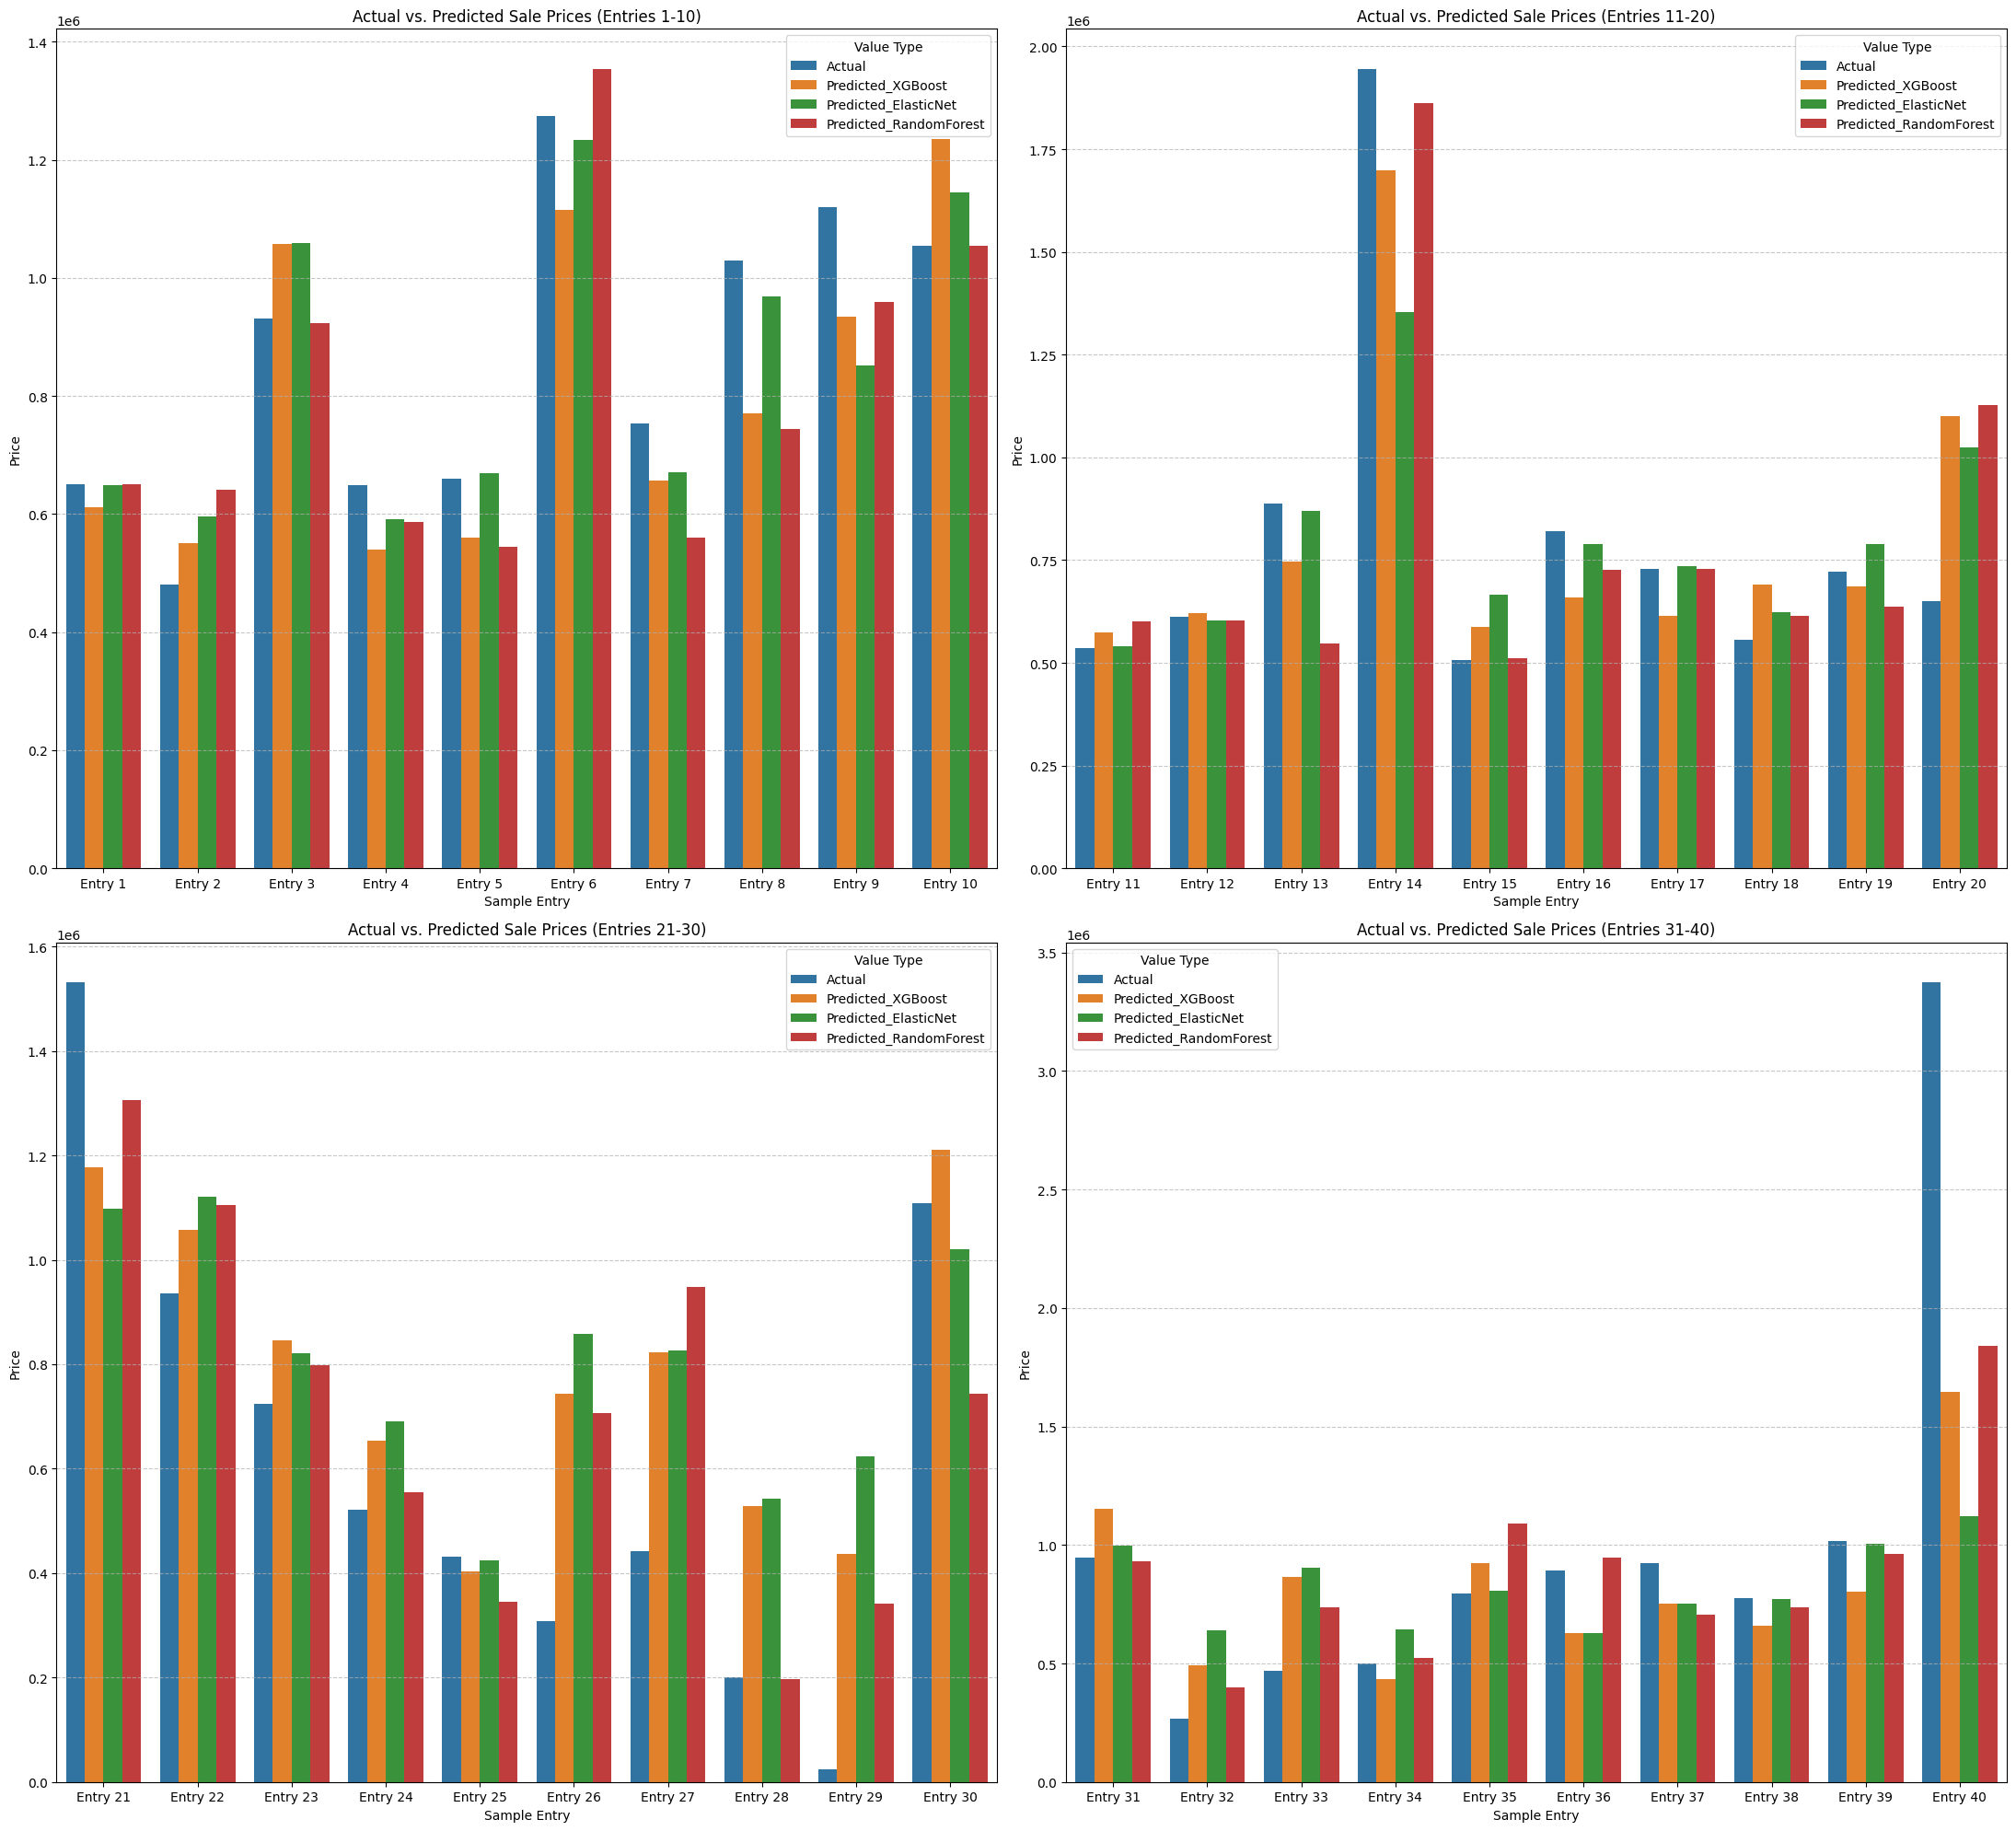

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to make the original index a column for plotting
plot_df = predictions_vs_actual.reset_index()

# Create 'Entry X' labels
plot_df['entry_label'] = [f'Entry {i+1}' for i in range(len(plot_df))]

plt.figure(figsize=(22, 20))

models_to_plot = ['Actual', 'Predicted_XGBoost', 'Predicted_ElasticNet', 'Predicted_RandomForest']

for i in range(4):
    start_idx = i * 10
    end_idx = (i + 1) * 10
    subset_df = plot_df.iloc[start_idx:end_idx]

    plot_subset = subset_df.melt(id_vars=['entry_label'],
                                 value_vars=models_to_plot,
                                 var_name='Metric', value_name='Price')

    plt.subplot(2, 2, i + 1)
    sns.barplot(x='entry_label', y='Price', hue='Metric', data=plot_subset, palette='tab10')
    plt.title(f'Actual vs. Predicted Sale Prices (Entries {start_idx+1}-{end_idx})')
    plt.xlabel('Sample Entry')
    plt.ylabel('Price')
    plt.xticks(rotation=0, ha='center')
    plt.legend(title='Value Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Locally Weighted Regression Curves (Actual vs. Predicted)
Plots with a locally weighted regression (LOESS) curve for each model is generated. This type of curve is more adaptive than a simple polynomial and can better reflect the 'native' trend of how each model's predictions relate to the actual values without imposing a fixed functional form. This gives a good visual sense of the general agreement between actual and predicted values for each model.

The plots above now display Locally Weighted Regression (LOESS) curves for each model, showing a non-parametric, flexible curve that adapts to the local distribution of the data. This provides a 'native' smoothed view of how each model's predictions align with the actual sale prices, without imposing a rigid polynomial shape. This type of curve is often better at revealing complex, non-linear relationships in tabular data.

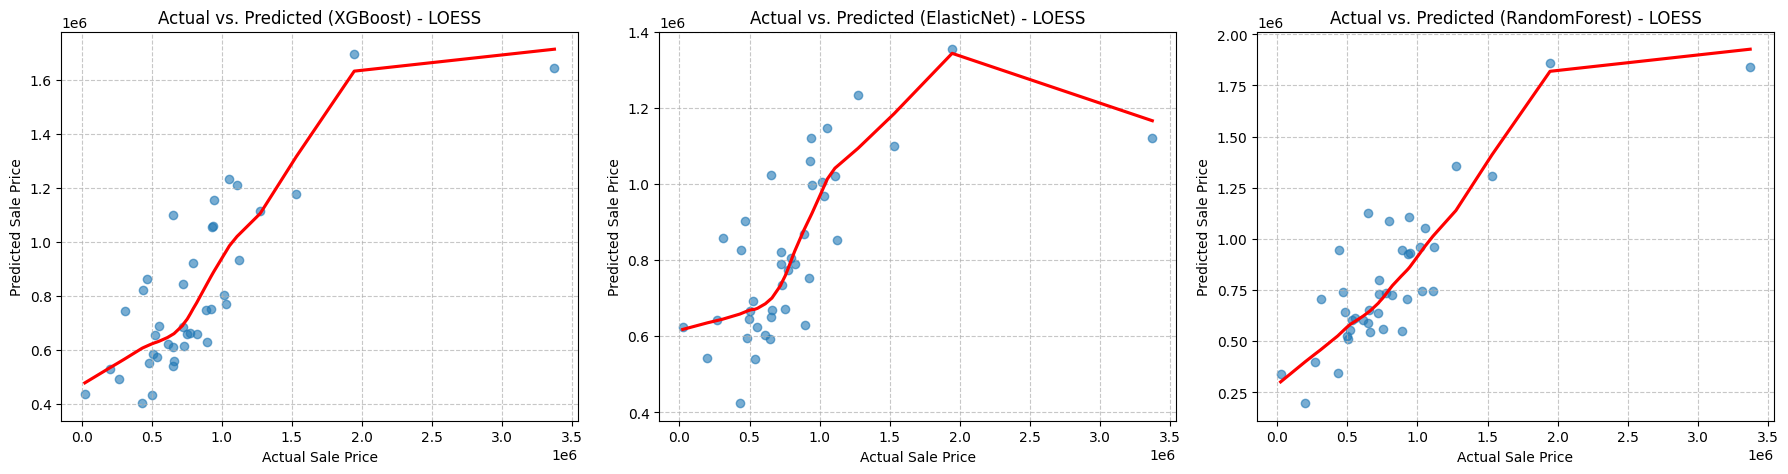

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 5))

# XGBoost Regplot with LOESS curve
plt.subplot(1, 3, 1)
sns.regplot(x='Actual', y='Predicted_XGBoost', data=predictions_vs_actual, scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, lowess=True)
plt.title('Actual vs. Predicted (XGBoost) - LOESS')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.grid(True, linestyle='--', alpha=0.7)

# ElasticNet Regplot with LOESS curve
plt.subplot(1, 3, 2)
sns.regplot(x='Actual', y='Predicted_ElasticNet', data=predictions_vs_actual, scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, lowess=True)
plt.title('Actual vs. Predicted (ElasticNet) - LOESS')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.grid(True, linestyle='--', alpha=0.7)

# RandomForest Regplot with LOESS curve
plt.subplot(1, 3, 3)
sns.regplot(x='Actual', y='Predicted_RandomForest', data=predictions_vs_actual, scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, lowess=True)
plt.title('Actual vs. Predicted (RandomForest) - LOESS')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()